In [1277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv("data.csv")

print(data.head())
print("Total number of rows: ", data.shape[0])

     COUNTRY CODE_TIME          TIME  YEAR  MONTH MONTH_NAME  \
0  Australia   JAN2010  January 2010  2010      1    January   
1  Australia   JAN2010  January 2010  2010      1    January   
2  Australia   JAN2010  January 2010  2010      1    January   
3  Australia   JAN2010  January 2010  2010      1    January   
4  Australia   JAN2010  January 2010  2010      1    January   

                   PRODUCT      VALUE  DISPLAY_ORDER  yearToDate  \
0                    Hydro    990.728              1   16471.891   
1                     Wind    409.469              2    4940.909   
2                    Solar     49.216              3     908.238   
3               Geothermal      0.083              4       0.996   
4  Total combustible fuels  19289.730              7  214302.969   

   previousYearToDate     share  
0                 NaN  0.047771  
1                 NaN  0.019744  
2                 NaN  0.002373  
3                 NaN  0.000004  
4                 NaN  0.930108  
To

In [1278]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Convert to percentage
    
    return mae, mse, rmse, mape

In [1279]:
data = data.drop(columns=['YEAR'])
data = data.drop(columns=['MONTH'])
data = data.drop(columns=['TIME'])
data = data.drop(columns=['MONTH_NAME'])
data = data.drop(columns=['PRODUCT'])


data = data[data['COUNTRY'] == 'Canada']


data = data.drop(columns=['yearToDate'])
data = data.drop(columns=['previousYearToDate'])
data = data.drop(columns=['share'])


data = data.drop(columns=['COUNTRY'])


data = data.dropna()


data = data.groupby('CODE_TIME', sort=False)['VALUE'].sum().reset_index()


data = data.rename(columns={'VALUE': 'TOTAL_VALUE'})

print(data)

print("Total number of rows: ", data.shape[0])

    CODE_TIME    TOTAL_VALUE
0     JAN2010  380439.654000
1     FEB2010  335806.949000
2     MAR2010  332629.260000
3     APR2010  288853.132000
4     MAY2010  281428.739000
..        ...            ...
151   AUG2022  335877.989983
152   SEP2022  297854.033968
153   OCT2022  300958.899006
154   NOV2022  333156.793664
155   DEC2022  384719.763580

[156 rows x 2 columns]
Total number of rows:  156


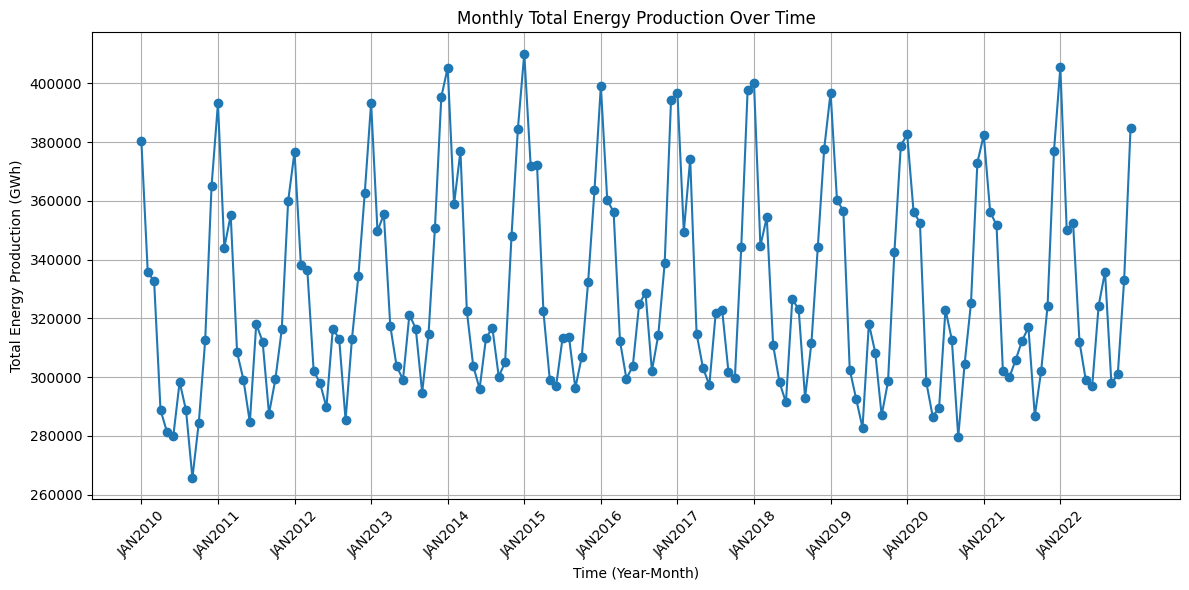

In [1280]:

plt.figure(figsize=(12, 6))
plt.plot(data['CODE_TIME'], data['TOTAL_VALUE'], marker='o')


plt.xlabel('Time (Year-Month)')
plt.ylabel('Total Energy Production (GWh)')
plt.title('Monthly Total Energy Production Over Time')


plt.xticks(ticks=range(0, len(data['CODE_TIME']), 12), labels=data['CODE_TIME'][::12], rotation=45)

plt.grid(True)
plt.tight_layout() 
plt.show()

In [1281]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['TOTAL_VALUE'].values.reshape(-1, 1))

print(scaled_data)

[[0.79437507]
 [0.48541914]
 [0.46342258]
 [0.16039604]
 [0.109003  ]
 [0.09841776]
 [0.22627958]
 [0.15929371]
 [0.        ]
 [0.13046439]
 [0.32396949]
 [0.68794434]
 [0.88239539]
 [0.54275213]
 [0.61915251]
 [0.29576778]
 [0.23131818]
 [0.13105957]
 [0.36268636]
 [0.32134282]
 [0.15121799]
 [0.23255936]
 [0.34995081]
 [0.65227094]
 [0.76843091]
 [0.5009575 ]
 [0.49088472]
 [0.25216796]
 [0.22353184]
 [0.16647943]
 [0.3521155 ]
 [0.32755017]
 [0.13619365]
 [0.32804373]
 [0.47489329]
 [0.6702943 ]
 [0.88366512]
 [0.58171846]
 [0.62126819]
 [0.35883768]
 [0.26301335]
 [0.23197506]
 [0.38458496]
 [0.35209048]
 [0.2010161 ]
 [0.33915936]
 [0.58909351]
 [0.89791537]
 [0.96646684]
 [0.64496679]
 [0.7702943 ]
 [0.39349298]
 [0.26403588]
 [0.21012377]
 [0.32937651]
 [0.35391769]
 [0.23883231]
 [0.27281426]
 [0.56992569]
 [0.82295292]
 [1.        ]
 [0.73602686]
 [0.73804911]
 [0.39268018]
 [0.23090838]
 [0.21754541]
 [0.32957278]
 [0.33290354]
 [0.21189124]
 [0.2846579 ]
 [0.46061639]
 [0.67

In [1282]:
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


look_back = 12 
X, y = create_dataset(scaled_data, look_back)


X = X.reshape(X.shape[0], X.shape[1], 1)

print(X)
print(y)

[[[0.79437507]
  [0.48541914]
  [0.46342258]
  ...
  [0.13046439]
  [0.32396949]
  [0.68794434]]

 [[0.48541914]
  [0.46342258]
  [0.16039604]
  ...
  [0.32396949]
  [0.68794434]
  [0.88239539]]

 [[0.46342258]
  [0.16039604]
  [0.109003  ]
  ...
  [0.68794434]
  [0.88239539]
  [0.54275213]]

 ...

 [[0.25314555]
  [0.40548206]
  [0.77003853]
  ...
  [0.40557149]
  [0.4859109 ]
  [0.22270196]]

 [[0.40548206]
  [0.77003853]
  [0.9673058 ]
  ...
  [0.4859109 ]
  [0.22270196]
  [0.24419442]]

 [[0.77003853]
  [0.9673058 ]
  [0.58448665]
  ...
  [0.22270196]
  [0.24419442]
  [0.46707427]]]
[0.88239539 0.54275213 0.61915251 0.29576778 0.23131818 0.13105957
 0.36268636 0.32134282 0.15121799 0.23255936 0.34995081 0.65227094
 0.76843091 0.5009575  0.49088472 0.25216796 0.22353184 0.16647943
 0.3521155  0.32755017 0.13619365 0.32804373 0.47489329 0.6702943
 0.88366512 0.58171846 0.62126819 0.35883768 0.26301335 0.23197506
 0.38458496 0.35209048 0.2010161  0.33915936 0.58909351 0.89791537
 0.96

In [1283]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(y_train)
print(y_test)

[0.88239539 0.54275213 0.61915251 0.29576778 0.23131818 0.13105957
 0.36268636 0.32134282 0.15121799 0.23255936 0.34995081 0.65227094
 0.76843091 0.5009575  0.49088472 0.25216796 0.22353184 0.16647943
 0.3521155  0.32755017 0.13619365 0.32804373 0.47489329 0.6702943
 0.88366512 0.58171846 0.62126819 0.35883768 0.26301335 0.23197506
 0.38458496 0.35209048 0.2010161  0.33915936 0.58909351 0.89791537
 0.96646684 0.64496679 0.7702943  0.39349298 0.26403588 0.21012377
 0.32937651 0.35391769 0.23883231 0.27281426 0.56992569 0.82295292
 1.         0.73602686 0.73804911 0.39268018 0.23090838 0.21754541
 0.32957278 0.33290354 0.21189124 0.2846579  0.46061639 0.67760251
 0.92411377 0.65516009 0.62666291 0.32276137 0.2341145  0.26295829
 0.40951981 0.43613959 0.25232718 0.33681659 0.50559934 0.89145188
 0.90768194 0.58014936 0.75209111 0.34032513 0.25953267 0.21896955
 0.38912963 0.39646174 0.24943654 0.23453667 0.54395071 0.91444477
 0.92966938 0.54703791 0.61424458 0.31272912 0.22509025 0.17820

In [1284]:

model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

In [1285]:

model.compile(optimizer='adam', loss='mean_squared_error')

In [1286]:

model.fit(X_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1973
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0903 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0792 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0691 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0700 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0697 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0780 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0642 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0573 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0573 
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0619 
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0620 
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0613 
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0578 
Epoch 16/100
4/4 ━━━

In [1287]:

predictions = model.predict(X_test)


predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


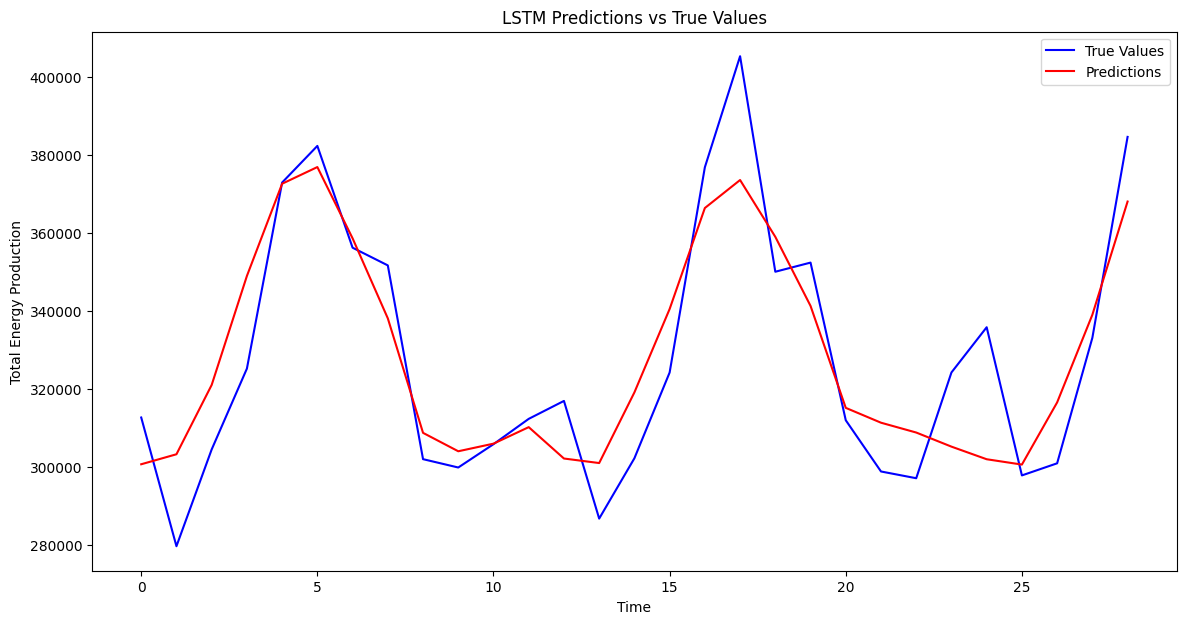

In [1288]:

plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='True Values', color='blue')
plt.plot(predictions, label='Predictions', color='red')
plt.title('LSTM Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Total Energy Production')
plt.legend()
plt.show()

In [1289]:

rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inverse - predictions) / y_test_inverse)) * 100

mae_lstm, mse_lstm, rmse_lstm, mape_lstm = calculate_metrics(y_test_inverse, predictions)
print(f"LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}, MAPE: {mape_lstm}")

LSTM - MAE: 12296.751148068965, MSE: 224091356.86874884, RMSE: 14969.681254747838, MAPE: 3.769132022412297


In [1290]:

data['CODE_TIME'] = pd.to_datetime(data['CODE_TIME'], format='%b%Y')
data.set_index('CODE_TIME', inplace=True)
print(data)

              TOTAL_VALUE
CODE_TIME                
2010-01-01  380439.654000
2010-02-01  335806.949000
2010-03-01  332629.260000
2010-04-01  288853.132000
2010-05-01  281428.739000
...                   ...
2022-08-01  335877.989983
2022-09-01  297854.033968
2022-10-01  300958.899006
2022-11-01  333156.793664
2022-12-01  384719.763580

[156 rows x 1 columns]


<Figure size 1200x800 with 0 Axes>

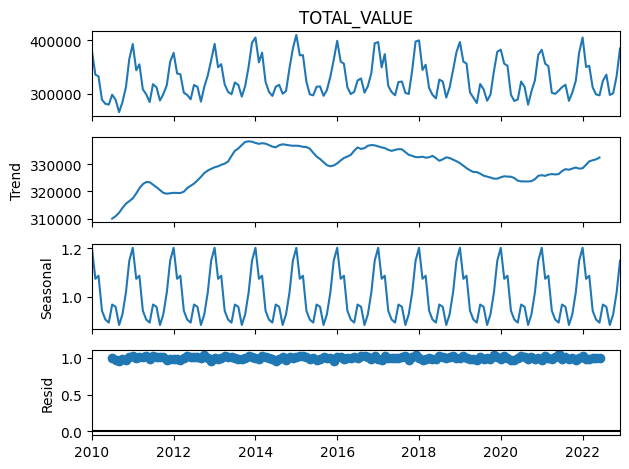

In [1291]:

decomposition = seasonal_decompose(data['TOTAL_VALUE'], model='multiplicative', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

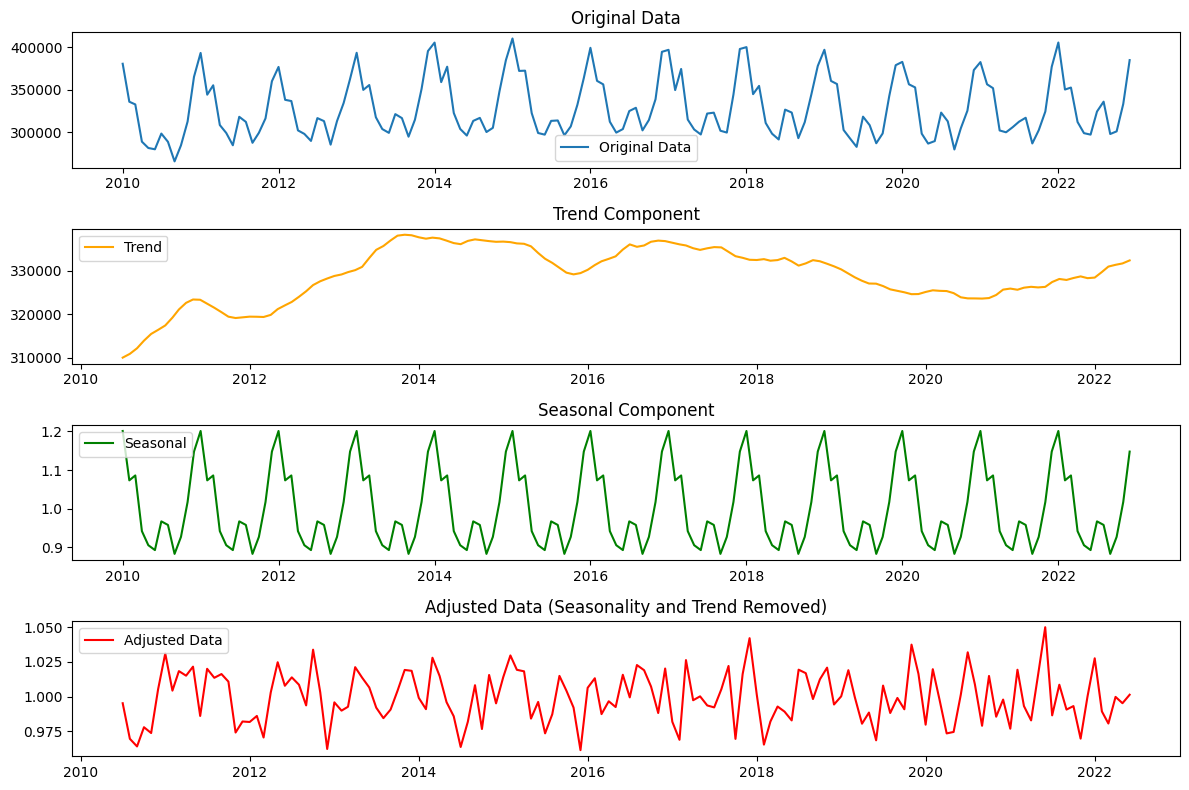

In [1292]:

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(data['TOTAL_VALUE'], label='Original Data')
plt.title('Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Adjusted Data', color='red')
plt.title('Adjusted Data (Seasonality and Trend Removed)')
plt.legend()

plt.tight_layout()
plt.show()

In [1293]:

residual_clean = residual.dropna()

In [1294]:

residual_clean.index = pd.to_datetime(residual_clean.index)


residual_clean = residual_clean.asfreq('MS')


split_index = int(len(residual_clean) * 0.8)


train_data = residual_clean[:split_index]
test_data = residual_clean[split_index:]

<Figure size 1000x500 with 0 Axes>

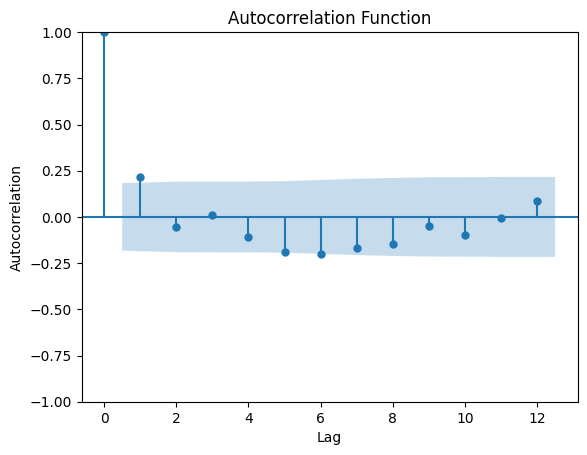

In [1295]:

plt.figure(figsize=(10, 5))
plot_acf(train_data, lags=12)  
plt.title("Autocorrelation Function")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

<Figure size 1200x600 with 0 Axes>

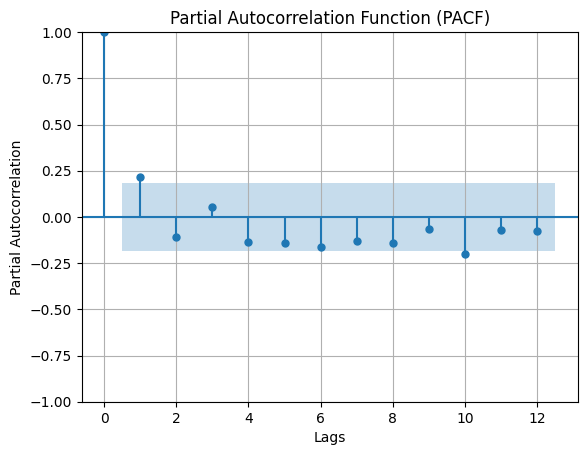

In [1296]:

plt.figure(figsize=(12, 6))
plot_pacf(train_data, lags=12, method='ywm') 
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [1297]:

model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

model_fit = model.fit(disp=False, maxiter=500)

In [1298]:

print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              resid   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 246.429
Date:                            Sun, 27 Oct 2024   AIC                           -482.859
Time:                                    23:50:09   BIC                           -469.734
Sample:                                07-01-2010   HQIC                          -477.544
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2235      0.111      2.014      0.044       0.006       0.441
ma.L1         -0.9734      0.234   

In [1299]:
forecast = model_fit.forecast(steps=len(test_data))

SARIMA - MAE: 0.017587852726254193, MSE: 0.0004478678191881253, RMSE: 0.021162887779982327, MAPE: 1.755518250865596


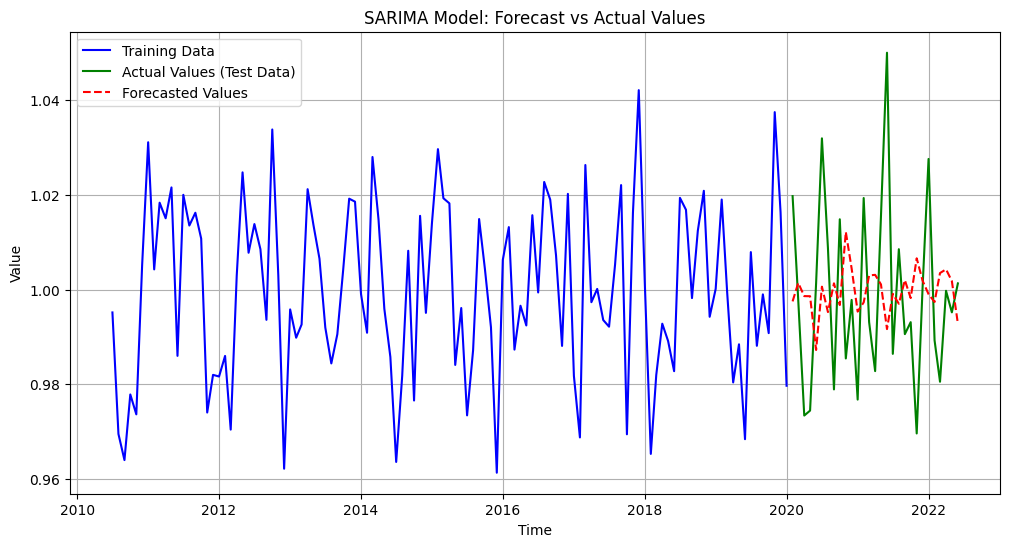

In [1300]:

mae = mean_absolute_error(test_data, forecast)


mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100  # MAPE in percentage



mae_sarima, mse_sarima, rmse_sarima, mape_sarima = calculate_metrics(test_data, forecast)
print(f"SARIMA - MAE: {mae_sarima}, MSE: {mse_sarima}, RMSE: {rmse_sarima}, MAPE: {mape_sarima}")


plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label="Training Data", color="blue")
plt.plot(test_data.index, test_data, label="Actual Values (Test Data)", color="green")
plt.plot(test_data.index, forecast, label="Forecasted Values", color="red", linestyle="--")


plt.xlabel("Time")
plt.ylabel("Value")
plt.title("SARIMA Model: Forecast vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()

In [1301]:
print(train_data.index)

DatetimeIndex(['2010-07-01', '2010-08-01', '2010-09-01', '2010-10-01',
               '2010-11-01', '2010-12-01', '2011-01-01', '2011-02-01',
               '2011-03-01', '2011-04-01',
               ...
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01'],
              dtype='datetime64[ns]', name='CODE_TIME', length=115, freq='MS')


Best parameters found:  {'C': 10000, 'epsilon': 0.01}
SVR - MAE: 7867.800803250344, MSE: 121624670.2354687, RMSE: 11028.357549312077, MAPE: 2.397979194228909


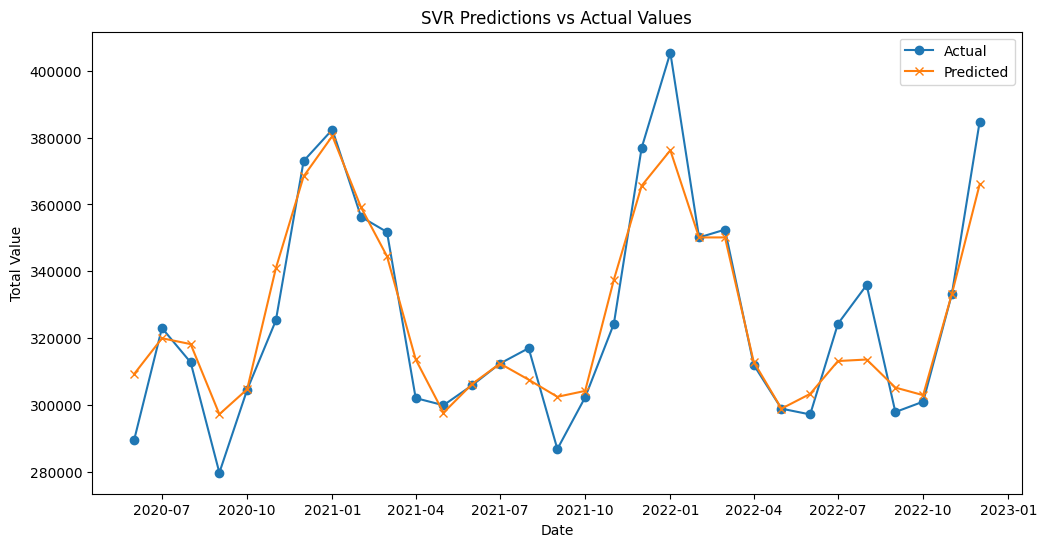

In [1302]:

data['month'] = data.index.month
data['year'] = data.index.year
data['lag_1'] = data['TOTAL_VALUE'].shift(1)
data['lag_2'] = data['TOTAL_VALUE'].shift(2)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data.dropna(inplace=True)

X = data[['month', 'year', 'lag_1', 'lag_2', 'month_sin', 'month_cos']]
y = data['TOTAL_VALUE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

tscv = TimeSeriesSplit(n_splits=5)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

svr = SVR()

param_grid = {
    'C': [0.1, 1, 10, 100, 1000,10000],
    'epsilon': [0.01, 0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_scaled, y)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)


best_svr = SVR(C=best_params['C'], epsilon=best_params['epsilon'])
best_svr.fit(X_scaled, y)


y_pred = best_svr.predict(X_scaled[-len(X_test):])


mae_svr, mse_svr, rmse_svr, mape_svr = calculate_metrics(y_test, y_pred)
print(f"SVR - MAE: {mae_svr}, MSE: {mse_svr}, RMSE: {rmse_svr}, MAPE: {mape_svr}")

plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual', marker='o')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Total Value')
plt.title('SVR Predictions vs Actual Values')
plt.legend()
plt.show()

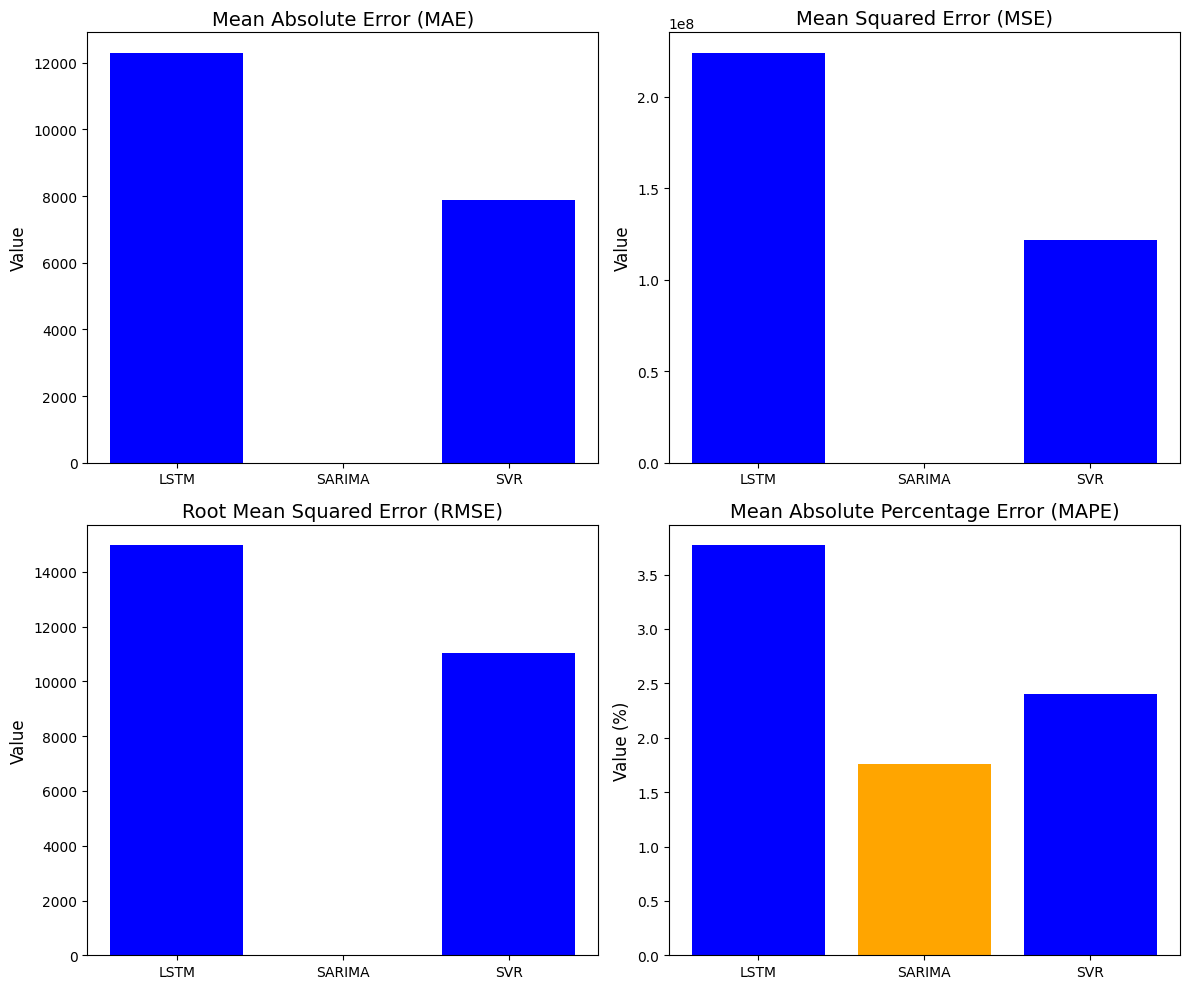

In [1303]:

metrics_data = {
    'Model': ['LSTM', 'SARIMA', 'SVR'],
    'MAE': [mae_lstm, mae_sarima, mae_svr],
    'MSE': [mse_lstm, mse_sarima, mse_svr],
    'RMSE': [rmse_lstm, rmse_sarima, rmse_svr],
    'MAPE (%)': [mape_lstm, mape_sarima, mape_svr]
}


metrics_df = pd.DataFrame(metrics_data)


metrics_df.set_index('Model', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs = axs.flatten()


axs[0].bar(metrics_df.index, metrics_df['MAE'], color=['blue', 'orange'])
axs[0].set_title('Mean Absolute Error (MAE)', fontsize=14)
axs[0].set_ylabel('Value', fontsize=12)



axs[1].bar(metrics_df.index, metrics_df['MSE'], color=['blue', 'orange'])
axs[1].set_title('Mean Squared Error (MSE)', fontsize=14)
axs[1].set_ylabel('Value', fontsize=12)

axs[2].bar(metrics_df.index, metrics_df['RMSE'], color=['blue', 'orange'])
axs[2].set_title('Root Mean Squared Error (RMSE)', fontsize=14)
axs[2].set_ylabel('Value', fontsize=12)

axs[3].bar(metrics_df.index, metrics_df['MAPE (%)'], color=['blue', 'orange'])
axs[3].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=14)
axs[3].set_ylabel('Value (%)', fontsize=12)

plt.tight_layout()
plt.show()
